# NeRF Demo

## Imports

In [2]:
import os

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

import run_nerf
from load_blender import load_blender_data


2026-01-18 18:41:22.222276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load example data

In [2]:
BASEDIR = "./logs"
EXP_NAME = "lego_example"
CONFIG = os.path.join(BASEDIR, EXP_NAME, "config.txt")

parser = run_nerf.config_parser()
args = parser.parse_args(["--config", CONFIG])

print(open(CONFIG, "r").read())

images, poses, render_poses, hwf, i_split = load_blender_data(
    args.datadir, args.half_res, args.testskip
)

if args.white_bkgd:
    images = images[..., :3] * images[..., -1:] + (1.0 - images[..., -1:])
else:
    images = images[..., :3]

H, W, focal = hwf
H, W = int(H), int(W)

print("images", images.shape)
print("poses", poses.shape)
print("hwf", (H, W, float(focal)))

expname = lego_example
basedir = ./logs
datadir = ./data/nerf_synthetic/lego
dataset_type = blender

half_res = True
no_batching = True

N_samples = 64
N_importance = 64

use_viewdirs = True

white_bkgd = True

N_rand = 1024



2026-01-18 18:32:09.285399: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1768757529.287649   60093 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3952 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:65:00.0, compute capability: 8.9
2026-01-18 18:32:10.010564: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1413120000 exceeds 10% of free system memory.
2026-01-18 18:32:11.101052: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1413120000 exceeds 10% of free system memory.


images (138, 400, 400, 3)
poses (138, 4, 4)
hwf (400, 400, 555.5555155968841)


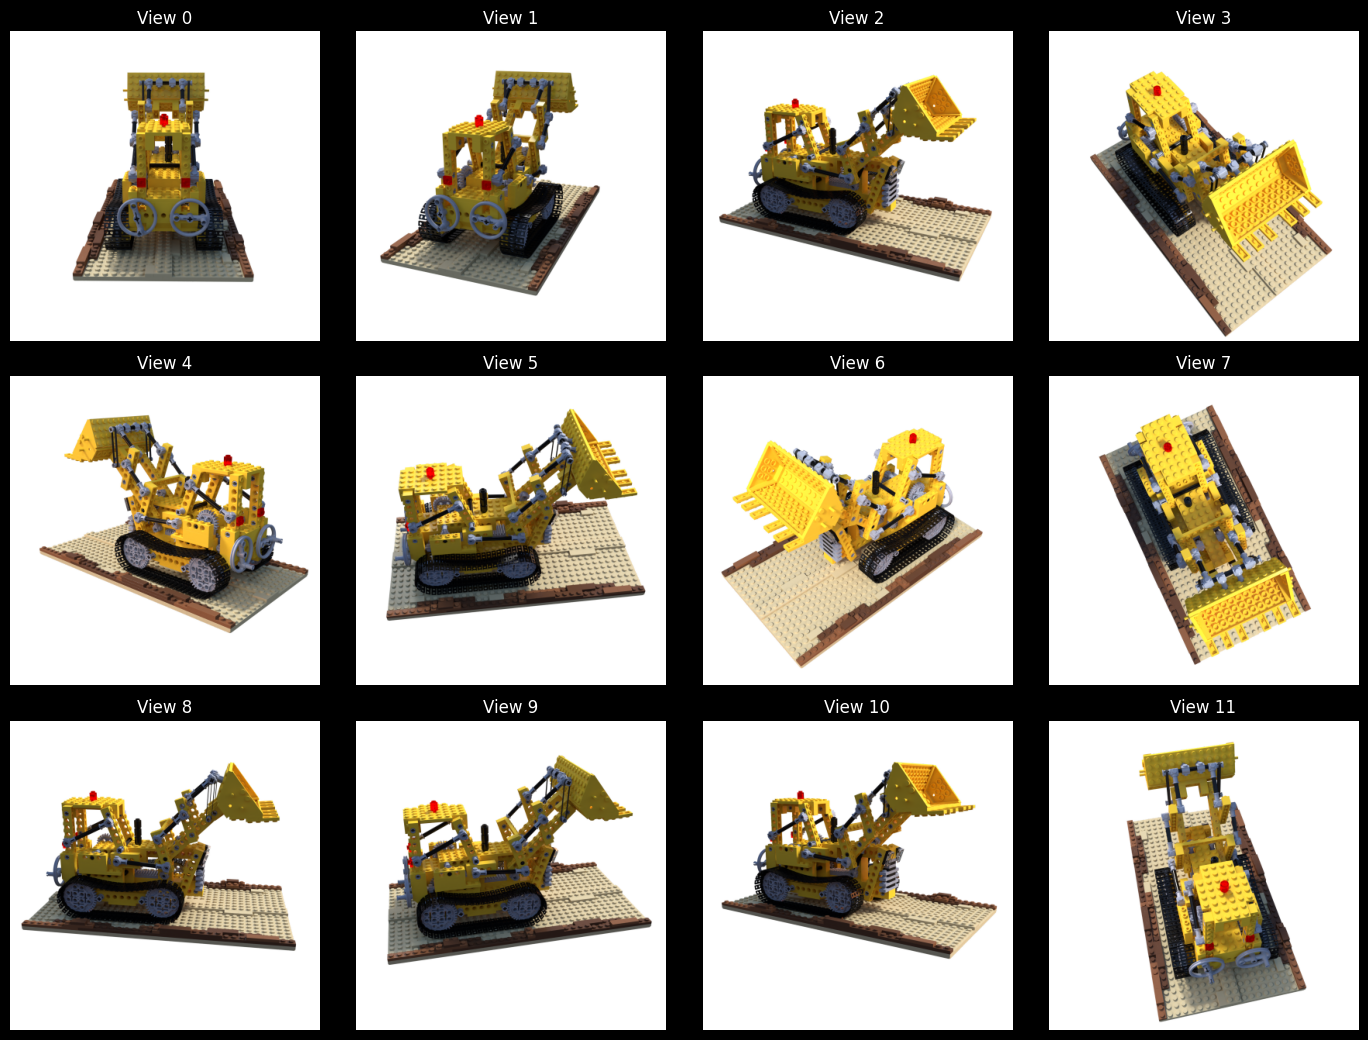

In [3]:
def show_grid(imgs, n=6, cols=4):
    n = min(n, len(imgs))
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(3.5 * cols, 3.5 * rows))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(np.clip(imgs[i], 0.0, 1.0))
        ax.set_title(f"View {i}")
        ax.axis("off")
    plt.tight_layout()

show_grid(images, 12)


## Camera positions

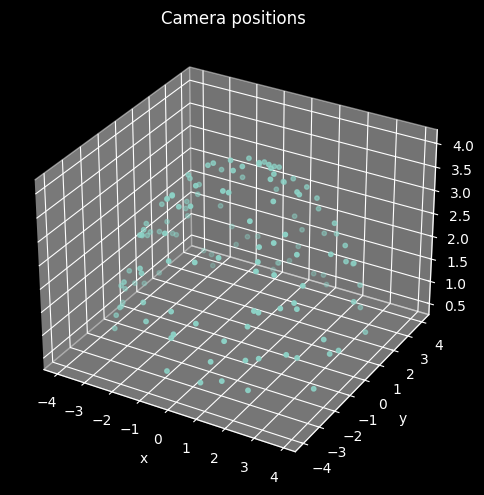

In [ ]:
centers = poses[:, :3, 3]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=10)
ax.set_title("Camera positions")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()

## Load NeRF Modell (pretrained)

In [5]:
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

render_kwargs_test.update({
    "near": tf.cast(2.0, tf.float32),
    "far": tf.cast(6.0, tf.float32),
})

render_kwargs_fast = dict(render_kwargs_test)
render_kwargs_fast["N_importance"] = 0


MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Not ndc!
Found ckpts ['./logs/lego_example/model_200000.npy']
Reloading from ./logs/lego_example/model_200000.npy
Resetting step to 200001
Reloading fine from ./logs/lego_example/model_fine_200000.npy


## Output single RGB + Depth image

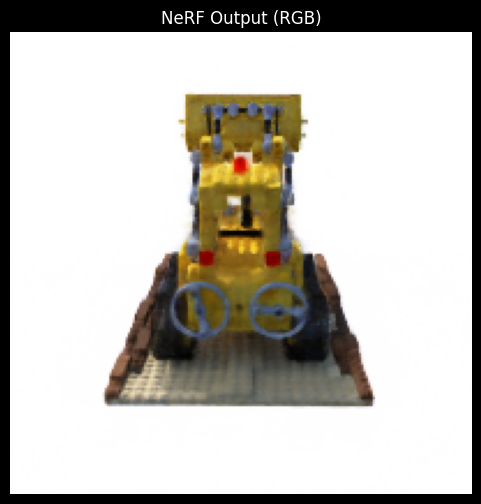

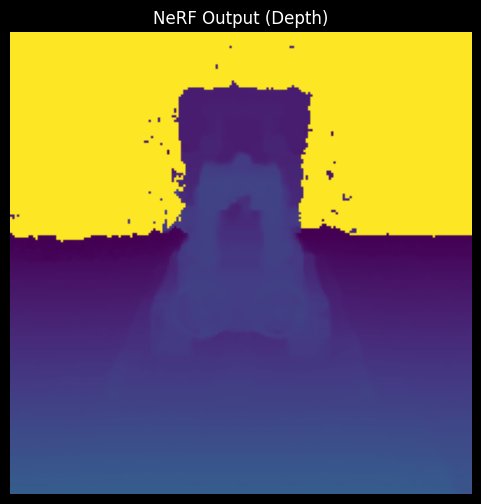

In [6]:
down = 2

c2w = poses[0, :3, :4]
rgb, disp, acc, _ = run_nerf.render(
    H // down, W // down, focal / down, c2w=c2w, **render_kwargs_fast
)

plt.figure(figsize=(6, 6))
plt.imshow(np.clip(rgb, 0.0, 1.0))
plt.title("NeRF Output (RGB)")
plt.axis("off");


plt.figure(figsize=(6, 6))
plt.imshow(np.clip(disp, 0.0, 1.0))
plt.title("NeRF Output (Depth)")
plt.axis("off");

## Turntable-Video (Novel View Synthesis)

In [7]:
down = 4
num_frames = 30
frames = []

for i, c2w in enumerate(render_poses[:num_frames]):
    rgb, _, _, _ = run_nerf.render(
        H // down, W // down, focal / down, c2w=c2w[:3, :4], **render_kwargs_fast
    )
    frames.append((255 * np.clip(rgb, 0.0, 1.0)).astype(np.uint8))

os.makedirs("outputs", exist_ok=True)
video_path = "outputs/nerf_lego_turntable.mp4"

display_obj = None
try:
    imageio.mimwrite(video_path, frames, fps=20, quality=8)
    from IPython.display import Video

    display_obj = Video(video_path, height=320)
except Exception as exc:
    gif_path = "outputs/nerf_lego_turntable.gif"
    imageio.mimsave(gif_path, frames, fps=20)
    from IPython.display import Image

    print("MP4 fehlgeschlagen, fallback auf GIF:", exc)
    display_obj = Image(gif_path)

display_obj


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
